In [16]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
#Load Data
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')

#Shuffle
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# input image dimensions
img_rows, img_cols = images.shape[1], images.shape[2]

if K.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    images = images.reshape(images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

images = images.astype('float32')
images /= 255

#80/10/10% splits for training/validation and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.2)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5)

In [18]:
#“common sense” accuracy
def common_sense_accuracy(predicted, actual):

    pred_minutes = predicted[0]*60+predicted[1]
    actual_minutes = actual[0]*60+actual[1]

    abs_diff = abs(pred_minutes-actual_minutes)
    
    return min(abs_diff, 12*60-abs_diff)

In [19]:
def re_category(labels):

    transformed_labels = labels[:][0] + labels[:][0] / 60
    return transformed_labels

train_labels2 = np.array([re_category(h) for h in train_labels])
val_labels2= np.array([re_category(h) for h in val_labels])
test_labels2 = np.array([re_category(h) for h in test_labels])

/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - loss: 14.4448 - mae: 3.2122 - val_loss: 12.4800 - val_mae: 3.0267 - learning_rate: 0.0010
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - loss: 12.9033 - mae: 3.1048 - val_loss: 12.1271 - val_mae: 3.0083 - learning_rate: 0.0010
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - loss: 12.7891 - mae: 3.0965 - val_loss: 11.9115 - val_mae: 2.9523 - learning_rate: 0.0010
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - loss: 11.8586 - mae: 2.9023 - val_loss: 10.0402 - val_mae: 2.5547 - learning_rate: 0.0010
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - loss: 10.4490 - mae: 2.6222 - val_loss: 8.6481 - val_mae: 2.2973 - learning_rate: 0.0010
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - loss: 8.9361 - mae: 2.3655 - val_loss: 6.9572 - val_mae: 2.0223 - learning_rate: 0.0010
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - loss: 7.3208 - mae: 2.0892 - val_loss: 6.0115 - val_mae: 1.8988 - learn

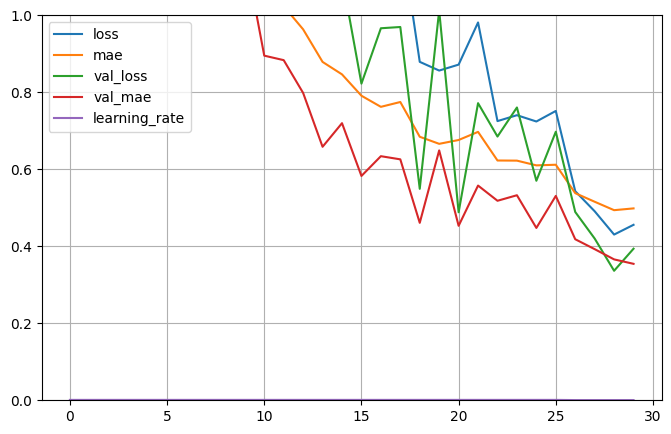

Validation loss: 0.39372751116752625
Validation MAE: 0.3543984591960907
Test loss: 0.5112224817276001
Test MAE: 0.3815683126449585


In [ ]:
batch_size = 32
epochs = 30
# Build Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))


model.compile(loss='mean_squared_error',  
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['mae'])

# Fit Model
Learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history = model.fit(train_images, train_labels2,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(val_images, val_labels2),
          callbacks=[Learning_rate])

df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
# Evaluate Model
score = model.evaluate(val_images, val_labels2, verbose=0)
print('Validation loss:', score[0])
print('Validation MAE:', score[1])
score_final = model.evaluate(test_images, test_labels2, verbose=0)
print('Test loss:', score_final[0])
print('Test MAE:', score_final[1])

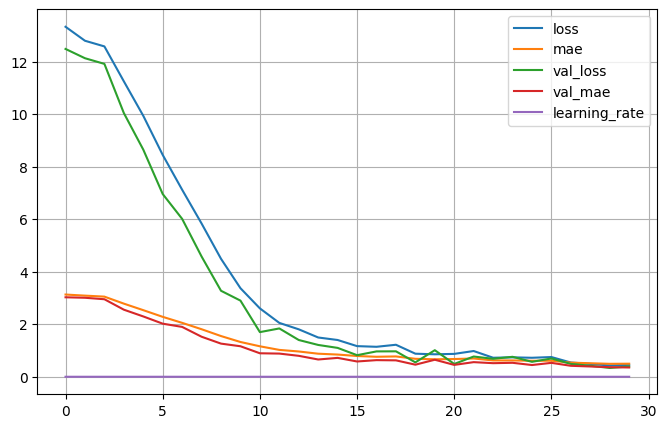

In [24]:
df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [21]:
def calculate_time_from_predictions(predictions):
    
    hours = np.floor(predictions).astype(int)
    
    minutes = ((predictions - hours) * 60).astype(int)
    return hours, minutes

In [22]:
predictions = model.predict(test_images)
predicted_hours, predicted_minutes = calculate_time_from_predictions(predictions)
predicted_hours = predicted_hours.flatten()
predicted_minutes = predicted_minutes.flatten()
common_sense_errors = [common_sense_accuracy([predicted_hours[i], predicted_minutes[i]], test_labels[i]) 
                       for i in range(len(test_labels))]
print('Average common sense error:', np.mean(common_sense_errors))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Average common sense error: 32.36388888888889


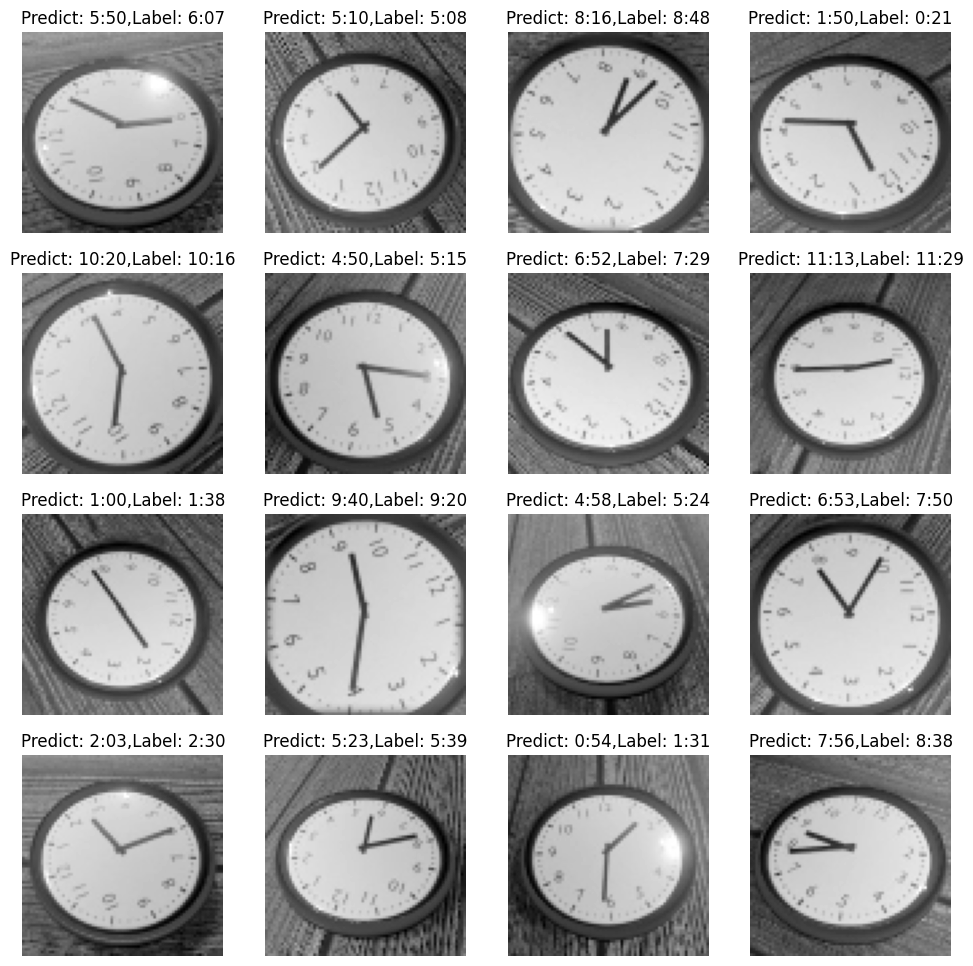

In [23]:
# Plot a sample of clock images
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f'Predict: {predicted_hours[i]}:{predicted_minutes[i]:02d},Label: {test_labels[i][0]}:{test_labels[i][1]:02d}')
    plt.axis('off')
plt.show()